# Optimization and Tuning Tutorial

You've learned how to build computational graphs in PyTorch and compute gradients. The final piece to training a network is applying the gradients to update the network parameters. In this tutorial you will learn how to implement a number of optimization methods in PyTorch. You will also learn to implement batch normalization and random dropout. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from collections import namedtuple
from IPython.display import Image
%matplotlib inline
np.random.seed(2018)

We use the PyTorch dataset API to load a dataset with exactly the same properties as the MNIST handwritten digits dataset:

- 28x28 images
- 10 classes
- Single color channel (B&W)
- Centered objects
- 50000 training set members
- 10000 test set members

Instead of handwritten digits, this dataset contains images of 10 different common clothing items. Performance on MNIST saturates quickly with simple network architectures and optimization methods. This dataset, known as Fashion-MNIST, is more difficult than MNIST and is useful to demonstrate the relative improvements of different optimization methods. 


In [2]:
class Fashion(datasets.MNIST):

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.urls = [
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
        ]
        super(Fashion, self).__init__( root, train=train, transform=transform, target_transform=target_transform, download=download)

train_data = Fashion('/tmp/data', train=True, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                            ]))

test_data = Fashion('/tmp/data', train=False, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ]))


def decode_label(l):
    return ["Top",
     "Trouser",
     "Pullover",
     "Dress",
     "Coat",
     "Sandal",
     "Shirt",
     "Sneaker",
     "Bag",
     "Ankle boot"
    ][l]


## Some examples from the Fashion-MNIST dataset.

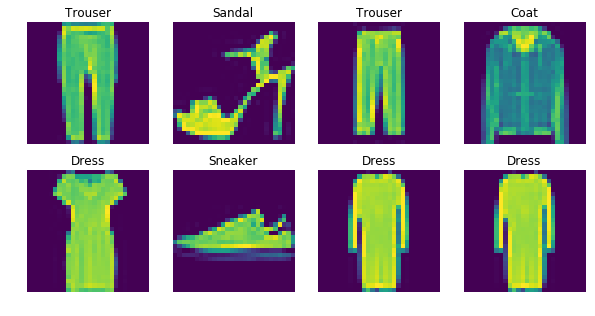

In [3]:
idxs = np.random.randint(100, size=8)
f, a = plt.subplots(2, 4, figsize=(10, 5))
for i in range(8):
    X = train_data.train_data[idxs[i]]
    Y = train_data.train_labels[idxs[i]]
    r, c = i // 4, i % 4
    a[r][c].set_title(decode_label(Y))
    a[r][c].axis('off')
    a[r][c].imshow(X.numpy())
plt.draw()

## Building the model

We are most interested in evaluating the performance of different optimization methods and training techniques so we will construct a very simple feedforward network.

In [4]:
class FashionModel(nn.Module):
    
    def __init__(self):
        super(FashionModel, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        return x
print(FashionModel())

FashionModel(
  (fc1): Linear(in_features=784, out_features=64)
  (fc2): Linear(in_features=64, out_features=32)
  (fc3): Linear(in_features=32, out_features=10)
)


## Parameter Initialization

While training a network, the initial value of the weights plays a significant role. In the extreme case, an oracle could just set the weights directly to values that minimize the objective function, and in practical cases a good initialization can bring us to a more favorable starting position in the parameter space. 

This raises the question of how to choose these weights. What happens if all the weights are set to zero? The gradients become zero, and the network finds itself without a direction. What if all of them are set to the same non-zero value? Although the gradients are no longer zero, each neuron has the same weight and follows the same gradient. Such neurons will continue to have the same value, since they're identical! So any initialization scheme must break this symmetry somehow, and randomly initializing the weights is a first step in that direction.

Let's begin with creating a weight initialization function that samples from N(0,1). A clean way of initializing the weights is to access the network parameters by traversing all modules inside the network, and then applying the desired initialization. This method also allows us to encapsulate all the initializations into a single function.




In [5]:
def init_randn(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0,1)

Now let's use this scheme to initialize the network.

Note that apply(fn) applies the function fn recursively to every submodule (as returned by .children()) as well as self. Also, since it is applied to itself as well, you must take care to select the appropriate type of module m and apply the initialization to it!

In [6]:
normalmodel = FashionModel()
normalmodel.apply(init_randn)

FashionModel(
  (fc1): Linear(in_features=784, out_features=64)
  (fc2): Linear(in_features=64, out_features=32)
  (fc3): Linear(in_features=32, out_features=10)
)

## Custom initializations

We could also choose a different way to initialize the weights, where you explicitly copy some values into the weights.

In [7]:
def init_custom(m):
    if type(m) == nn.Linear:
        rw = torch.randn(m.weight.data.size())
        m.weight.data.copy_(rw)

custommodel = FashionModel()
custommodel.apply(init_custom)

FashionModel(
  (fc1): Linear(in_features=784, out_features=64)
  (fc2): Linear(in_features=64, out_features=32)
  (fc3): Linear(in_features=32, out_features=10)
)

## Your turn!

Now let's use this initialization scheme to implement Xavier initialization. 

Xavier initialization is a way of initializing the weights such that the variance of the inputs is the same as the variance of the outputs. At each layer, the fan_in and fan_out (i.e. input connections and output connections) might be different. To calculate the variance, you will multiply each weight with the inputs. Evidently, if the number of inputs is less, they will need to be multiplied with higher weights so that they can sum up to the product of a larger number of outputs with smaller weights. This is the intuition behind Xavier initialization.

HINT: You can see the size of the input weight matrix using m.weight.size()

In [8]:
def init_xavier(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size()[1]
        fan_out = m.weight.size()[0]
        std = np.sqrt(2.0 / (fan_in + fan_out))
        m.weight.data.normal_(0,std)

In [9]:
xaviermodel = FashionModel()
xaviermodel.apply(init_xavier)

FashionModel(
  (fc1): Linear(in_features=784, out_features=64)
  (fc2): Linear(in_features=64, out_features=32)
  (fc3): Linear(in_features=32, out_features=10)
)

## Putting the initializations to the test


Now let's train, test, and visualize the performance of these models.

In [10]:
train_size = train_data.train_data.shape[0]
val_size, train_size = int(0.20 * train_size), int(0.80 * train_size) # 80 / 20 train-val split
test_size = test_data.test_data.shape[0]
batch_size = 100

# add dataset to dataloader that handles batching
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(val_size, val_size+train_size)))
val_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(0, val_size)))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# setup metric class
Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])

In [11]:
def inference(model, loader, n_members):
    correct = 0
    for data, label in loader:
        X = Variable(data.view(-1, 784))
        Y = Variable(label)
        out = model(X)
        pred = out.data.max(1, keepdim=True)[1]
        predicted = pred.eq(Y.data.view_as(pred))
        correct += predicted.sum()
    return correct / n_members

class Trainer():
    """ A simple training cradle
    """
    
    def __init__(self, model, optimizer, load_path=None):
        self.model = model
        if load_path is not None:
            self.model = torch.load(load_path)
        self.optimizer = optimizer
        
    def stop_cond(self):
        # TODO: Implement early stopping
        def deriv(ns):
            return [ns[i+1] - ns[i] for i in range(len(ns)-1)]
        val_errors = [m.val_error for m in self.metrics]
        back = val_errors[-10:]
        return sum(deriv(back)) > 0
            
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def run(self, epochs):
        print("begin training...")
        self.metrics = []
        for e in range(n_epochs):
            if self.stop_cond():
                return
            epoch_loss = 0
            correct = 0
            for batch_idx, (data, label) in enumerate(train_loader):
                self.optimizer.zero_grad()
                X = Variable(data.view(-1, 784))
                Y = Variable(label)
                out = self.model(X)
                pred = out.data.max(1, keepdim=True)[1]
                predicted = pred.eq(Y.data.view_as(pred))
                correct += predicted.sum()
                loss = F.nll_loss(out, Y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.data[0]
            total_loss = epoch_loss/train_size
            train_error = 1.0 - correct/train_size
            val_error = 1.0 - inference(self.model, val_loader, val_size)
            print("epoch: {0}, loss: {1:.8f}".format(e+1, total_loss))
            self.metrics.append(Metric(loss=total_loss, 
                                  train_error=train_error,
                                  val_error=val_error))
         

In [12]:
### TRAIN MODELS ###
n_epochs = 20

optimizer = torch.optim.Adam(normalmodel.parameters(), lr=0.01)
normaltrainer = Trainer(normalmodel, optimizer)
normaltrainer.run(n_epochs)
normaltrainer.save_model('./normal_init_model.pt')
print('')

optimizer = torch.optim.Adam(custommodel.parameters(), lr=0.01)
customtrainer = Trainer(custommodel, optimizer)
customtrainer.run(n_epochs)
customtrainer.save_model('./custom_init_model.pt')
print('')

optimizer = torch.optim.Adam(xaviermodel.parameters(), lr=0.01)
xaviertrainer = Trainer(xaviermodel, optimizer)
xaviertrainer.run(n_epochs)
xaviertrainer.save_model('./xavier_init_model.pt')
print('')


### TEST ###
normalmodel = FashionModel()
normalmodel.load_state_dict(torch.load('./normal_init_model.pt'))
test_acc_normal = inference(normalmodel, test_loader, test_size)
print("Test accuracy of normal initialized model: {0:.2f}".format(test_acc_normal * 100))

custommodel = FashionModel()
custommodel.load_state_dict(torch.load('./custom_init_model.pt'))
test_acc_custom = inference(custommodel, test_loader, test_size)
print("Test accuracy of custom initialized model: {0:.2f}".format(test_acc_custom * 100))

xaviermodel = FashionModel()
xaviermodel.load_state_dict(torch.load('./xavier_init_model.pt'))
test_acc_xavier = inference(xaviermodel, test_loader, test_size)
print("Test accuracy of xavier initialized model: {0:.2f}".format(test_acc_xavier * 100))



begin training...


/Users/rajatkuls/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


epoch: 1, loss: 0.21279161
epoch: 2, loss: 0.01641757
epoch: 3, loss: 0.01263594
epoch: 4, loss: 0.01085610
epoch: 5, loss: 0.00974486
epoch: 6, loss: 0.00896448
epoch: 7, loss: 0.00848017
epoch: 8, loss: 0.00808881
epoch: 9, loss: 0.00811287
epoch: 10, loss: 0.00764723
epoch: 11, loss: 0.00775033
epoch: 12, loss: 0.00753748
epoch: 13, loss: 0.00691765
epoch: 14, loss: 0.00622008
epoch: 15, loss: 0.00581120
epoch: 16, loss: 0.00566051
epoch: 17, loss: 0.00585296
epoch: 18, loss: 0.00554308
epoch: 19, loss: 0.00517059
epoch: 20, loss: 0.00499828

begin training...
epoch: 1, loss: 0.17301077
epoch: 2, loss: 0.01660598
epoch: 3, loss: 0.01202936
epoch: 4, loss: 0.01087482
epoch: 5, loss: 0.01026419
epoch: 6, loss: 0.00983682
epoch: 7, loss: 0.00968466
epoch: 8, loss: 0.00920667
epoch: 9, loss: 0.00903230
epoch: 10, loss: 0.00879332
epoch: 11, loss: 0.00866730
epoch: 12, loss: 0.00840482
epoch: 13, loss: 0.00821132
epoch: 14, loss: 0.00749119
epoch: 15, loss: 0.00705454
epoch: 16, loss: 0.

## Visualization

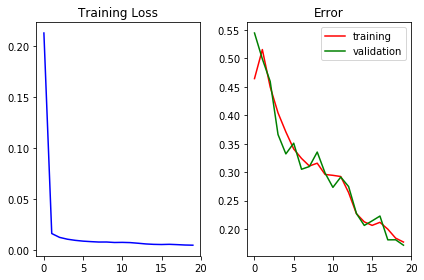

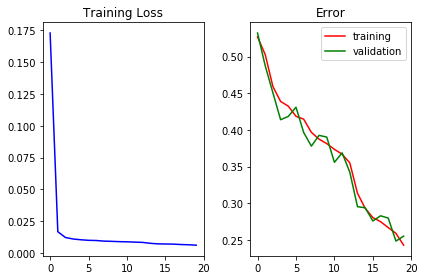

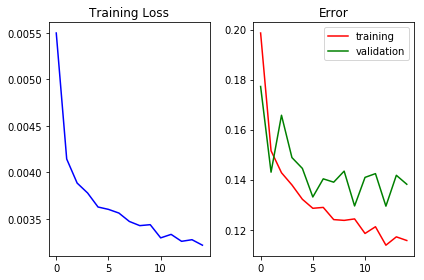

In [13]:
### VISUALIZATION ###
def training_plot(metrics):
    plt.figure(1)
    plt.subplot(121)
    plt.plot([m.loss for m in metrics], 'b')
    plt.title('Training Loss')

    plt.subplot(122)
    plt.plot([m.train_error for m in metrics], 'r', label='training')
    plt.plot([m.val_error for m in metrics], 'g', label='validation')
    plt.title('Error')
    plt.legend()
    plt.tight_layout()
    plt.show()

training_plot(normaltrainer.metrics)
training_plot(customtrainer.metrics)
training_plot(xaviertrainer.metrics)

## Using pretrained weights

In the previous section we saw that initializations can start the training from a good spot. In addition to these schemes, you might also need to have specific methods to initialize the weights in different layers. For example, you might want to use a pretrained model like Alexnet to give your network a head start for visual recognition tasks. Let's load the pretrained Alexnet model and see how it works.

In [ ]:
alexnet_model = models.alexnet(pretrained=True)


## A Simple Optimizer in PyTorch

The most simple optimization method is to update the network parameters by adding the negative of the gradient scaled by a fixed learning rate $\eta$.

$$ \textbf{W'} \leftarrow \textbf{W} - \eta \nabla L(\textbf{W}) $$

PyTorch provides us a very simple and expressive API for creating custom optimizers. An optimizer in PyTorch subclasses `torch.optim.Optimizer` and is required to specify two methods.

`__init__`: Must call the superclass `__init__` and provide a list of network parameters, `params`, to optimize and a dictionary of default values provided to each parameter group, `defaults`. 

`step`: Performs an update on the network parameters. 

The meat of your optimizer logic lies in the `step` method. In this method you should update your model parameters with the help of some useful internal datastructures. Let's define these to make the following code more clear.

`self.param_groups`: When you initialize an optimizer object, you are required to provide the list of parameter objects to be optimized. In the case of `FashionModel`, there are 6 parameters -- each `Linear` layer has a weight matrix parameter and a bias vector. All of these 6 parameters are considered within a single `param_group`. This `group` will be a dictionary with an entry `params` that contains an iterable of all 6 parameters, as well as entries for all `defaults`. These `defaults` are generally useful for storing small values like hyperparameters that are standard across all parameter groups. There are more advanced cases where it can come in handy to have different values for certain entities depending on the `param_group`. 

`self.state`: This maintains state for a given parameter. Essentially it maps a parameter to a dictionary of data that you want to keep track of. This is useful in cases where you want to keep state on a per-parameter basis.

**IMPORTANT**: Unlike most other use cases in PyTorch, operations on parameters and state data should be done inplace. This ensures that the updated parameters are not updated copies of the original. In the following sample implementations, you may see some unfamiliar operations. Functions like `torch.add_` and `torch.mul_` are just inplace analogues of standard PyTorch functions. See http://pytorch.org/docs/master/torch.html for further details.

Below is a simple example of an optimizer that performs vanilla (stochastic) gradient descent.

In [26]:
class VanillaOptim(torch.optim.Optimizer):
    
    def __init__(self, params, lr=0.01):
        # set default learning rate for all parameters
        defaults = dict(lr=lr)
        super(VanillaOptim, self).__init__(params, defaults)
        
    def step(self):
        """Performs a single optimization step.
        """
        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']: 
                d_p = p.grad.data
                p.data.add_(-lr * d_p)

## Adding Momentum

We can make use of the `self.state` data-structure to maintain a copy of an accumulated gradient that we also decay at each step. Once again we use inplace operations to avoid unneccesary buffer allocation. Recall a standard update with momentum given decay rate $\mu$.

$$ \begin{align}
\textbf{V'} &= \mu \textbf{V} - \eta \nabla L(\textbf{W})\\
\textbf{W'} &= \textbf{W} + \textbf{V'}\\
\end{align}
$$

In the following code, we call the decayed accumulated gradient $\textbf{V}$ in the `self.state` data-structure `momentum_buffer`.

In [27]:
class MomentumOptim(torch.optim.Optimizer):
    
    def __init__(self, params, lr=0.01, momentum=0.9):
        # set default learning rate for all parameters
        defaults = dict(lr=lr, momentum=momentum)
        super(MomentumOptim, self).__init__(params, defaults)

    def step(self):
        """Performs a single optimization step with momentum
        """
        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            for p in group['params']:
                d_p = p.grad.data
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    buf = param_state['momentum_buffer'] = torch.zeros(d_p.size())
                else:
                    buf = param_state['momentum_buffer']
                buf.mul_(momentum).add_(d_p)
                p.data.add_(-lr * buf)

## Your turn!

Follow the algorithm outline provided from the original paper to implement the Adam optimizer. We have provided you with training loop code as well. Once you have completed the optimizer code you should try training and noting relative test performance using vanilla, momentum, and Adam optimizers.

In [28]:
#Image("http://www.andrew.cmu.edu/user/rbrigden/adam_algorithm.png")

In [29]:
class AdamOptim(torch.optim.Optimizer):
    def __init__(self, params, alpha=0.001, beta1=0.9, beta2=0.999):
        # set default learning rate for all parameters
        defaults = dict(alpha=alpha, beta1=beta1, beta2=beta2)
        super(AdamOptim, self).__init__(params, defaults)

    def step(self):
        """Performs a single optimization step with ADAM
        """
        for group in self.param_groups:
            eps = 1e-8
            alpha = group['alpha']
            beta1 = group['beta1']
            beta2 = group['beta2']
            for p in group['params']:
                d_p = p.grad.data
                param_state = self.state[p]
                if 'first_moment' not in param_state:
                    first_moment = param_state['first_moment'] = torch.zeros(d_p.size())
                    second_moment = param_state['second_moment'] = torch.zeros(d_p.size())
                    t = param_state['time_step'] = torch.zeros(1)
                else:
                    first_moment = param_state['first_moment']
                    second_moment = param_state['second_moment']
                    t = param_state['time_step']
                t.add_(1)
                first_moment.mul_(beta1).add_((1.0-beta1), d_p)
                second_moment.mul_(beta2).add_((1.0-beta2), d_p * d_p)
                corr1 = first_moment / (1.0 - beta1**t[0])
                corr2 = second_moment / (1.0 - beta2**t[0])
                p.data.add_(-alpha, corr1 / (torch.sqrt(corr2) + eps))

## Putting the Optimizers to the Test

Now that we have 3 different optimizers implemented, let's see how they compare head to head.

In [31]:
### TRAIN MODELS ###
n_epochs = 20

model = FashionModel()
optimizer = VanillaOptim(model.parameters())
vtrainer = Trainer(model, optimizer)
vtrainer.run(n_epochs)
vtrainer.save_model('./vanilla_optimized_model.pt')
print('')

model = FashionModel()
optimizer = MomentumOptim(model.parameters())
mtrainer = Trainer(model, optimizer)
mtrainer.run(n_epochs)
mtrainer.save_model('./momentum_optimizer_model.pt')
print('')

# UNCOMMENT TO TEST YOUR ADAM IMPLEMENTATION
model = FashionModel()
optimizer = AdamOptim(model.parameters())
atrainer = Trainer(model, optimizer)
atrainer.run(n_epochs)
atrainer.save_model('./adam_optimizer_model.pt')

begin training...


/Users/rajatkuls/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


epoch: 1, loss: 0.01140567
epoch: 2, loss: 0.00628077
epoch: 3, loss: 0.00541316
epoch: 4, loss: 0.00502096
epoch: 5, loss: 0.00475712
epoch: 6, loss: 0.00457129
epoch: 7, loss: 0.00442707
epoch: 8, loss: 0.00430085
epoch: 9, loss: 0.00418434
epoch: 10, loss: 0.00409677
epoch: 11, loss: 0.00399758
epoch: 12, loss: 0.00391401
epoch: 13, loss: 0.00384514
epoch: 14, loss: 0.00377757
epoch: 15, loss: 0.00372296
epoch: 16, loss: 0.00365672
epoch: 17, loss: 0.00360315
epoch: 18, loss: 0.00353193
epoch: 19, loss: 0.00348795
epoch: 20, loss: 0.00343997

begin training...
epoch: 1, loss: 0.00634555
epoch: 2, loss: 0.00408973
epoch: 3, loss: 0.00369687
epoch: 4, loss: 0.00347295
epoch: 5, loss: 0.00325693
epoch: 6, loss: 0.00312746
epoch: 7, loss: 0.00301944
epoch: 8, loss: 0.00286660
epoch: 9, loss: 0.00276231
epoch: 10, loss: 0.00269594
epoch: 11, loss: 0.00260721
epoch: 12, loss: 0.00251307
epoch: 13, loss: 0.00242938
epoch: 14, loss: 0.00238045
epoch: 15, loss: 0.00229995
epoch: 16, loss: 0.

In [32]:
### TEST ###
vmodel = FashionModel()
vmodel.load_state_dict(torch.load('./vanilla_optimized_model.pt'))
test_acc_vanilla = inference(vmodel, test_loader, test_size)
print("Test accuracy of vanilla optimized model: {0:.2f}".format(test_acc_vanilla * 100))

mmodel = FashionModel()
mmodel.load_state_dict(torch.load('./momentum_optimizer_model.pt'))
test_acc_momentum = inference(mmodel, test_loader, test_size)
print("Test accuracy of momentum optimized model: {0:.2f}".format(test_acc_momentum * 100))

# UNCOMMENT TO TEST YOUR ADAM IMPLEMENTATION
amodel = FashionModel()
amodel.load_state_dict(torch.load('./adam_optimizer_model.pt'))
test_acc_adam = inference(amodel, test_loader, test_size)
print("Test accuracy of adam optimized model: {0:.2f}".format(test_acc_adam * 100))

/Users/rajatkuls/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Test accuracy of vanilla optimized model: 85.19
Test accuracy of momentum optimized model: 87.22
Test accuracy of adam optimized model: 87.82


## Visualization

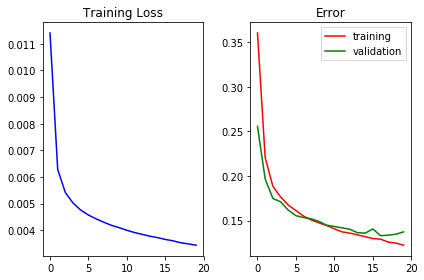

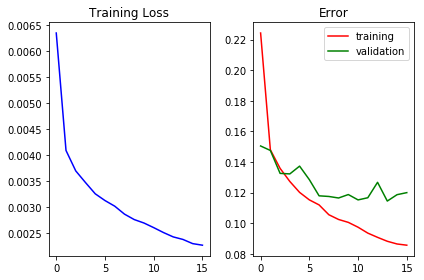

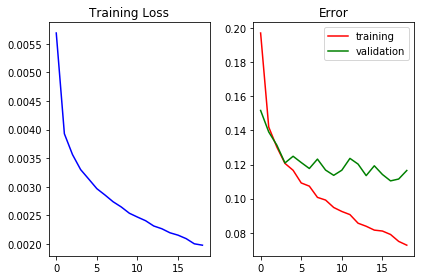

In [33]:
training_plot(vtrainer.metrics)
training_plot(mtrainer.metrics)
training_plot(atrainer.metrics)

## Batch Normalization

Batch normalization is a relatively simple but significant improvement in training neural networks. In machine learning, *covariate shift* is a phenomenon in which the covariate distribution is non-stationary over the course of training. This is a common phenomenon in online learning. When training a neural network on a fixed dataset, there is no covariate shift (excluding sample noise from minibatch approximation), but the distribution of individual node and layer activity shifts as the network parameters are updated. As an abstraction, we can consider each node's activity to be a covariate of the following nodes in the network. Thus we can think of the non-stationarity of node (and layer) activations as a sort of *internal covariate shift*. 

Why is internal covariate shift a problem? Each subsequent layer has to account for a shifting distribution of its inputs. For saturating non-linearities the problem becomes even more dire, as the shift in activity will more likely place the unit output in the saturated region of the non-linearity.

